### Usando nn.Embedings en lugar de glove o word2vec preentrenados

In [112]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Clase del modelo simplificada para procesar embeddings promedio
class SentimentANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SentimentANN, self).__init__()
        
        # Red neuronal para procesar el embedding promedio
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.f_sent = nn.Linear(hidden_size, output_size)
    
    def forward(self, embedding_avg):
        x = self.fc1(embedding_avg)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        output = self.f_sent(x)
        output = torch.tanh(output)
        return output.squeeze()

class SentimentModel:
    def __init__(self, vocab_size, embedding_dim, hidden_size, preprocessor, dropout=0.5, lr=0.001):
        self.Preprocessor = preprocessor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.model = SentimentANN(input_size=embedding_dim, hidden_size=hidden_size, output_size=1)
        self.loss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, X_train, y_train, epoch=10, batch_size=32):
        loss_list = []
        for e in range(epoch):
            total_loss = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Promediar los embeddings en batch
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                
                loss = self.loss(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        self.loss_list = loss_list

    def plot_loss(self):
        plt.plot(self.loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def evaluate(self, X_test, y_test):
        with torch.no_grad():
            outputs = self.model(X_test)
            total_loss = self.loss(outputs, y_test).item()
            mse = total_loss / len(y_test)
            print(f'MSE: {mse}')
        return mse

    def predict(self, texto):
        embedding_avg = self.Preprocessor.get_embedding_parrafo(texto)
        with torch.no_grad():
            output = self.model(embedding_avg)
        return output.item()

class Preprocessor:
    def __init__(self, path, embedding_dim):
        self.path = path
        self.embedding_dim = embedding_dim
        self.vocab, self.data = self._load_and_process_data()
        self.vocab_size = len(self.vocab)
        self.embedding_layer = nn.Embedding(self.vocab_size, embedding_dim)
        
    def _load_and_process_data(self):
        """Load text data and create vocabulary."""
        with open(self.path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        # Tokenize and create a list of unique words (vocabulary)
        tokens = re.findall(r'\w+', text.lower())
        vocab = {word: idx for idx, word in enumerate(set(tokens))}
        
        # Process the data to create sequences of token indices for model training
        data = [{'text': re.findall(r'\w+', para.lower()), 'sentiment': float(sent)} 
                for para, sent in zip(
                    re.findall(r'Parrafo_\d+:\n(.*?)\nsentimiento_\d+:\n', text, re.DOTALL),
                    re.findall(r'sentimiento_\d+:\n(.*?)(?:\n|$)', text, re.DOTALL)
                )]
        
        return vocab, data

    def get_embedding_texto(self, texto):
        tokens = [self.vocab.get(word, 0) for word in re.findall(r'\w+', texto.lower())]
        embeddings = self.embedding_layer(torch.tensor(tokens))
        return embeddings

    def get_embedding_parrafo(self, parrafo):
        embeddings = self.get_embedding_texto(parrafo)
        if embeddings.size(0) > 0:
            return embeddings.mean(dim=0).view(1, -1)
        else:
            return torch.zeros((1, self.embedding_dim))






In [113]:
# Inicializar el preprocesador para cargar los datos y crear el vocabulario
preprocessor = Preprocessor(path="./train_data.txt", embedding_dim=100)

In [119]:
# Crear el dataset con embeddings promedio
def create_dataset(preprocessor):
    X = []
    y = []
    for item in preprocessor.data:
        parrafo = item['text']
        sentimiento = item['sentiment']
        
        # Obtener el embedding promedio para el párrafo
        embedding_avg = preprocessor.get_embedding_parrafo(" ".join(parrafo))
        if embedding_avg.size(0) > 0:
            X.append(embedding_avg)  # Embedding promedio del párrafo
            y.append(sentimiento)  # Sentimiento correspondiente
        
    return torch.stack(X), torch.tensor(y, dtype=torch.float32)


In [120]:
# Crear el dataset
X_train, y_train = create_dataset(preprocessor)



In [121]:
X_train[0].shape

torch.Size([1, 100])

In [122]:
# Definir los parámetros del modelo
vocab_size = preprocessor.vocab_size
embedding_dim = 100
hidden_size = 64  # Puedes ajustar este tamaño
output_size = 1   # Salida de un solo valor para el sentimiento

# Crear el modelo de sentimiento bidireccional
model = SentimentBidirectional_RNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    output_size=output_size,
    Preprocessor=preprocessor,
    dropout=0.5,
    lr=0.001
)

In [123]:
# Entrenar el modelo
model.train(X_train, y_train, epoch=100, batch_size=32)

Epoch 1 - Loss: 4.193001211329829
Epoch 2 - Loss: 3.8597140121273696
Epoch 3 - Loss: 3.590032996609807
Epoch 4 - Loss: 3.284985238686204
Epoch 5 - Loss: 3.0171355130150914
Epoch 6 - Loss: 2.7518680803477764
Epoch 7 - Loss: 2.467034636065364
Epoch 8 - Loss: 2.1478677168488503
Epoch 9 - Loss: 1.8077735751867294
Epoch 10 - Loss: 1.4782107528299093
Epoch 11 - Loss: 1.1623254688456655
Epoch 12 - Loss: 0.8973540458828211
Epoch 13 - Loss: 0.6642204988747835
Epoch 14 - Loss: 0.4932378185912967
Epoch 15 - Loss: 0.37704243464395404
Epoch 16 - Loss: 0.29618777986615896
Epoch 17 - Loss: 0.249496687669307
Epoch 18 - Loss: 0.34816262125968933
Epoch 19 - Loss: 0.581011975184083
Epoch 20 - Loss: 1.1390722412616014
Epoch 21 - Loss: 1.1787369577214122
Epoch 22 - Loss: 0.7438931949436665
Epoch 23 - Loss: 0.4441917883232236
Epoch 24 - Loss: 0.2815160402096808
Epoch 25 - Loss: 0.20566638140007854
Epoch 26 - Loss: 0.22992257378064096
Epoch 27 - Loss: 0.2146006803959608
Epoch 28 - Loss: 0.16620735498145223
E

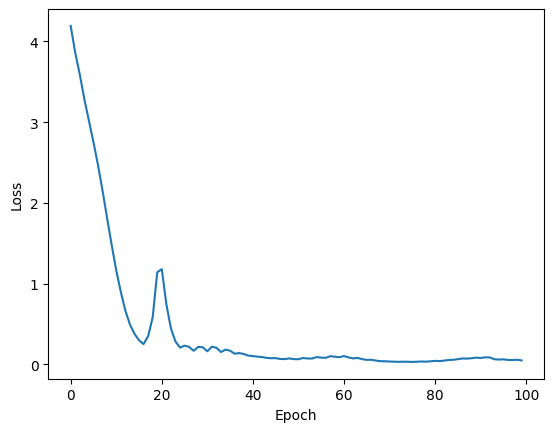

In [124]:
# Graficar la pérdida durante el entrenamiento
model.plot_loss()

In [137]:
# Predecir el sentimiento de un texto
texto = '''
Últimamente siento que nada tiene sentido. Cada vez que trato de avanzar, parece que algo se interpone y todo el esfuerzo se vuelve inútil.
A veces me pregunto para qué me esfuerzo tanto si al final siempre termino decepcionado.
Las cosas no mejoran, y cuando creo que hay una pequeña esperanza, algo sucede y todo vuelve a la oscuridad.
No importa cuánto lo intente, simplemente no veo un final positivo a todo esto. Siento que estoy atrapado en un ciclo sin salida.
'''
sentimiento = model.predict(texto)
print(f'Sentimiento: {sentimiento}')


Sentimiento: -0.5955748558044434


In [126]:
# Definimos las oraciones a evaluar
sentences = [
    'Hoy siento que tengo mucha energía y entusiasmo',
    'La vida no siempre es fácil, pero hay que seguir adelante',
    'Estoy cansado de todo, nada parece tener sentido',
    'Hoy fue un día normal, sin muchas novedades',
    'Me encanta pasar tiempo con mis amigos, me hace feliz',
    'No soporto la forma en la que me tratan, me siento mal',
    'Hoy fue uno de esos días en los que todo salió bien',
    'A veces creo que no tengo claro hacia dónde voy',
    'Hoy tuve una conversación inspiradora, me siento motivado'
]

# Definimos el valor de sentimiento esperado para cada oración
target_sentiment = [0.9, 0.4, -0.7, 0.0, 0.8, -0.8, 0.9, -0.2, 0.7]

In [127]:
import plotly.graph_objects as go

def evaluate_model_bidirectional_plotly(model, sentences, target_sentiment):
    # Obtener los sentimientos predichos
    predicted_sentiment = [model.predict(sentence) for sentence in sentences]

    # Imprimir la oracion, el sentimiento esperado y el sentimiento predicho
    for i, (sentence, target, predicted) in enumerate(zip(sentences, target_sentiment, predicted_sentiment)):
        print(f"Oración {i+1}: {sentence}")
        print(f"Sentimiento esperado: {target:.2f}")
        print(f"Sentimiento predicho: {predicted:.2f}")
        print()
    
    # Crear etiquetas para el eje x
    x_labels = [f"Oración {i+1}" for i in range(len(sentences))]
    
    # Crear el gráfico de barras agrupadas
    fig = go.Figure()

    # Sentimiento esperado
    fig.add_trace(go.Bar(
        x=x_labels,
        y=target_sentiment,
        name='Sentimiento esperado',
        marker=dict(color='rgba(55, 128, 191, 0.7)'),
    ))

    # Sentimiento predicho
    fig.add_trace(go.Bar(
        x=x_labels,
        y=predicted_sentiment,
        name='Sentimiento predicho',
        marker=dict(color='rgba(219, 64, 82, 0.7)'),
    ))

    # Personalizar el diseño del gráfico
    fig.update_layout(
        title="Comparación de Sentimiento Esperado vs. Sentimiento Predicho",
        xaxis_title="Oraciones",
        yaxis_title="Sentimiento",
        barmode='group',
        xaxis_tickangle=-45,
        template="plotly_white",
    )

    # Mostrar el gráfico
    fig.show()


In [128]:
# Evaluar el modelo
evaluate_model_bidirectional_plotly(model, sentences, target_sentiment)

Oración 1: Hoy siento que tengo mucha energía y entusiasmo
Sentimiento esperado: 0.90
Sentimiento predicho: 0.68

Oración 2: La vida no siempre es fácil, pero hay que seguir adelante
Sentimiento esperado: 0.40
Sentimiento predicho: 0.42

Oración 3: Estoy cansado de todo, nada parece tener sentido
Sentimiento esperado: -0.70
Sentimiento predicho: -0.37

Oración 4: Hoy fue un día normal, sin muchas novedades
Sentimiento esperado: 0.00
Sentimiento predicho: 0.04

Oración 5: Me encanta pasar tiempo con mis amigos, me hace feliz
Sentimiento esperado: 0.80
Sentimiento predicho: 0.69

Oración 6: No soporto la forma en la que me tratan, me siento mal
Sentimiento esperado: -0.80
Sentimiento predicho: -0.34

Oración 7: Hoy fue uno de esos días en los que todo salió bien
Sentimiento esperado: 0.90
Sentimiento predicho: 0.08

Oración 8: A veces creo que no tengo claro hacia dónde voy
Sentimiento esperado: -0.20
Sentimiento predicho: -0.50

Oración 9: Hoy tuve una conversación inspiradora, me sient